# DAT565 Introduction to Data Science and AI 
## 2023-2024, LP1
## Assignment 4: Spam classification using Naïve Bayes 
This assignment has three obligatory questions. Questions 4-5 are optional and will not be graded.

The exercise takes place in this notebook environment where you can chose to use Jupyter or Google Colabs. We recommend you use Google Colabs as it will facilitate remote group-work and makes the assignment less technical. 

*Tips:* 

* You can execute certain Linux shell commands by prefixing the command with a `!`. 
* You can insert Markdown cells and code cells. The first you can use for documenting and explaining your results, the second you can use to write code snippets that execute the tasks required.  

In this assignment you will implement a Naïve Bayes classifier in Python that will classify emails into spam and non-spam (“ham”) classes.  Your program should be able to train on a given set of spam and “ham” datasets. 

You will work with the datasets available at https://spamassassin.apache.org/old/publiccorpus/. There are three types of files in this location:

-	easy-ham: non-spam messages typically quite easy to differentiate from spam messages. 
-	hard-ham: non-spam messages more difficult to differentiate 
-	spam: spam messages 

**Execute the cell below to download and extract the data into the environment of the notebook -- it will take a few seconds.** 

If you chose to use Jupyter notebooks you will have to run the commands in the cell below on your local computer. Note that if you are using Windows, you can instead use (7zip)[https://www.7-zip.org/download.html] to decompress the data (you will have to modify the cell below).

**What to submit:** 

* Convert the notebook to a PDF file by compiling it, and submit the PDF file. 
* Make sure all cells are executed so all your code and its results are included. 
* Double-check that the PDF displays correctly before you submit it.

In [ ]:
# download and extract the data
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2
!tar -xjf 20021010_easy_ham.tar.bz2
!tar -xjf 20021010_hard_ham.tar.bz2
!tar -xjf 20021010_spam.tar.bz2

The data is now in the following three folders: `easy_ham`, `hard_ham`, and `spam`. You can confirm this via the following command:

In [ ]:
!ls -lah

### 1. Preprocessing: 
Note that the email files contain a lot of extra information, besides the actual message. Ignore that for now and run on the entire text (in the optional part further down, you can experiment with filtering out the headers and footers). 
1.	We don’t want to train and test on the same data (it might help to reflect on **why** ,if you don't recall). Split the spam and ham datasets into a training set and a test set. (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`). Use `easy_ham` for quesions 1 and 2.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score, confusion_matrix

# config inline plots
%matplotlib inline

# set seaborn style
sns.set_style('darkgrid')

In [4]:
def get_df_from_emails_files(folder_path, ham_value):
    file_names = os.listdir(folder_path)

    # You can filter out only files (excluding directories) using a list comprehension
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_names if os.path.isfile(os.path.join(folder_path, file_name))]

    df = pd.DataFrame()

    for file_path in file_paths:
        with open(file_path, "r", errors='replace') as file:
            content = file.read()
        df = df.append({"Content": content, "Ham": ham_value}, ignore_index=True)

    return df

In [5]:
# build easy spam dataframe
df_easy_ham = get_df_from_emails_files(folder_path='easy_ham', ham_value=True)

In [6]:
print(f'easy ham dataset shape: {df_easy_ham.shape}')
df_easy_ham.head()

easy ham dataset shape: (2551, 2)


,Content,Ham
0,From exmh-users-admin@redhat.com Wed Sep 11 1...,1.0
1,From rpm-list-admin@freshrpms.net Sat Oct 5 ...,1.0
2,From brian@unearthed.com Wed Aug 28 10:56:21 ...,1.0
3,From fork-admin@xent.com Sat Sep 21 20:22:10 ...,1.0
4,From pudge@perl.org Tue Sep 3 14:20:15 2002\...,1.0


In [7]:
# build easy spam dataframe
df_spam = get_df_from_emails_files(folder_path='spam', ham_value=False)

In [8]:
print(f'spam dataset shape: {df_spam.shape}')
df_spam.head()

spam dataset shape: (501, 2)


,Content,Ham
0,From gef@insiq.us Wed Sep 18 00:15:26 2002\nR...,0.0
1,From batomic@hotmail.com Tue Sep 3 14:53:03 ...,0.0
2,From lu5guxf4c4149@yahoo.com Wed Aug 28 15:39...,0.0
3,From firstever001@44yes.onlineisbest.com Thu ...,0.0
4,From frln@insiq.us Sat Sep 14 16:21:04 2002\n...,0.0


In [9]:
# write your pre-processing code here
# for both the easy spam and spam dataset, we will use
# the 33% of each of those as a test set 

easyhamtrain = df_easy_ham.sample(frac=0.67, random_state=42)
easyhamtest = df_easy_ham.drop(easyhamtrain.index)

spamtrain = df_spam.sample(frac=0.67, random_state=42)
spamtest = df_spam.drop(spamtrain.index)

### 2. Write a Python program that: 

1.	Uses the four datasets from Question 1 (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`).
2.	Trains a Naïve Bayes classifier (use the [scikit-learn library](https://scikit-learn.org/stable/)) on `hamtrain` and `spamtrain`, that classifies the test sets and reports True Positive and False Negative rates on the `hamtest` and `spamtest` datasets. You can use `CountVectorizer` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)) to transform the email texts into vectors. Please note that there are different types of Naïve Bayes Classifiers available in *scikit-learn* ([Documentation here](https://scikit-learn.org/stable/modules/naive_bayes.html)). Here, you will test two of these classifiers that are well suited for this problem:
  - Multinomial Naive Bayes
  - Bernoulli Naive Bayes.

Please inspect the documentation to ensure input to the classifiers is appropriate before you start coding. You may have to modify your input.

In [10]:
# Optionally, set a random seed for rows shuffle reproducibility
np.random.seed(42)

# construct the dataframe needed for the classsification task,
# starting from the ones in part 1 
df_easy = pd.concat([
    easyhamtrain, easyhamtest, spamtrain, spamtest
]).sample(frac=1)

In [11]:
df_easy.head()

,Content,Ham
443,From fork-admin@xent.com Thu Aug 29 11:04:08 ...,1.0
1502,From ilug-admin@linux.ie Mon Sep 2 16:21:52 ...,1.0
2416,From rssfeeds@jmason.org Mon Oct 7 12:05:42 ...,1.0
929,Return-Path: guido@python.org\nDelivery-Date: ...,1.0
1892,From exmh-users-admin@redhat.com Sat Sep 14 1...,1.0


In [12]:
# identify the feature column and the label column
X_easy = df_easy['Content']
y_easy = df_easy['Ham']

In [13]:
# convert the textual data into a matrix of token counts
X_easy = CountVectorizer().fit_transform(X_easy)

In [14]:
# train/test split
X_train_easy, X_test_easy, y_train_easy, y_test_easy = train_test_split(
    X_easy, y_easy, 
    test_size=0.33,
    shuffle=True,
    random_state=42,
)

In [15]:
# train a Multinomial Naive Bayes model and retrieve predictions
multinomialNB_model = MultinomialNB().fit(X_train_easy, y_train_easy)
y_predict_easy_multi = multinomialNB_model.predict(X_test_easy)

In [16]:
# train a Bernoulli Naive Bayes model and retrieve predictions
BernoulliNB_model = BernoulliNB().fit(X_train_easy,y_train_easy)
y_predict_easy_berno = BernoulliNB_model.predict(X_test_easy)

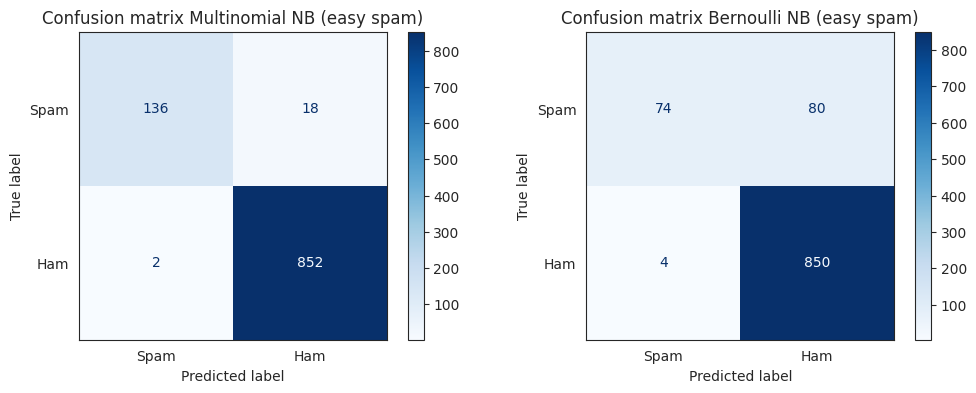

In [17]:
# visualize the confusion matrices to check the performances of the models
with sns.axes_style("white"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test_easy, y_predict_easy_multi),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[0],
        cmap=plt.cm.Blues, 
        values_format='d'
    )
    axes[0].set_title('Confusion matrix Multinomial NB (easy spam)')

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test_easy, y_predict_easy_berno),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[1],
        cmap=plt.cm.Blues, 
        values_format='d',
    )
    axes[1].set_title('Confusion matrix Bernoulli NB (easy spam)')

To measure the performance of the models we will use the `f1-score` for the target class imbalance.
The F1 score is a measure of a test's accuracy that considers both the precision and the recall of the test to compute the score. As the classes are not balanced, this is the measure that will be used as it corresponds to the harmonic mean of precision and recall.

In [18]:
print("F1 Score for multinomial Naive Bayes:", round(f1_score(y_test_easy, y_predict_easy_multi), 4))
print("F1 Score for Bernoulli Naive Bayes:", round(f1_score(y_test_easy, y_predict_easy_berno), 4))

F1 Score for multinomial Naive Bayes: 0.9884
F1 Score for Bernoulli Naive Bayes: 0.9529


Since in our case we mainly work with term frequencies using the `CountVectorizer` class, the `Multinomial Naive Bayes` performs better than the `Bernoulli Naive Bayes`. 
Here are some reasons why `Multinomial Naives Bayes` gives us better results:

- `Multinomial Naive Bayes` is often preferred when working with text data and considering term frequencies, while `Bernoulli Naive Bayes` is more appropriate when dealing with binary data and presence/absence of features, in this case presence or absence of words in an email.
- `Multinomial Naive Bayes` handles multiple occurrences of words within an email whereas `Bernoulli Naive Bayes` only considers the presence or absence of words in an email and ignores their frequency.

### 3. Run on hard ham:
Run the two models from Question 2 on `spam` versus `hard-ham`, and compare to the `easy-ham` results.

In [19]:
# build hard ham dataframe
hardham = get_df_from_emails_files(folder_path='hard_ham', ham_value=True)

print(f'Hard ham dataset shape: {hardham.shape}')
hardham.head()

Hard ham dataset shape: (250, 2)


,Content,Ham
0,Return-Path: <bounce-lgtech-2534369@sprocket.l...,1.0
1,Return-Path: <update@list.theregister.co.uk>\n...,1.0
2,Return-Path: <newsletter@jobfair24.de>\nReceiv...,1.0
3,Return-Path: ler@lerami.lerctr.org\nDelivery-D...,1.0
4,Return-Path: <bounce-lgtech-2534369@sprocket.l...,1.0


In [20]:
df_hard = pd.concat([
    hardham, spamtrain, spamtest
]).sample(frac=1)
X_hard = df_hard['Content']
y_hard = df_hard['Ham']

In [21]:
X_hard = CountVectorizer().fit_transform(X_hard)

In [22]:
X_train_hard ,X_test_hard ,y_train_hard ,y_test_hard = train_test_split(
    X_hard,y_hard,
    test_size=0.33,
    shuffle=True,
    random_state=42
)

In [23]:
# train a Multinomial Naive Bayes model and retrieve predictions
multinomialNB_model = MultinomialNB().fit(X_train_hard, y_train_hard)
y_predict_hard_multi = multinomialNB_model.predict(X_test_hard)

In [24]:
# train a Bernoulli Naive Bayes model and retrieve predictions
BernoulliNB_model = BernoulliNB().fit(X_train_hard,y_train_hard)
y_predict_hard_berno = BernoulliNB_model.predict(X_test_hard)

To compare the results between the 2 trained models using the `easy ham` first and then the `hard ham`, we will display the related confusion matrices. Then, we will use again the `f1-score` to further compare the performance between the 2 different datasets. Even though the hard ham dataset is much more balanced, we decided to keep the `f1-score` as performance measure to have a more coherent comparison with the easy ham case.

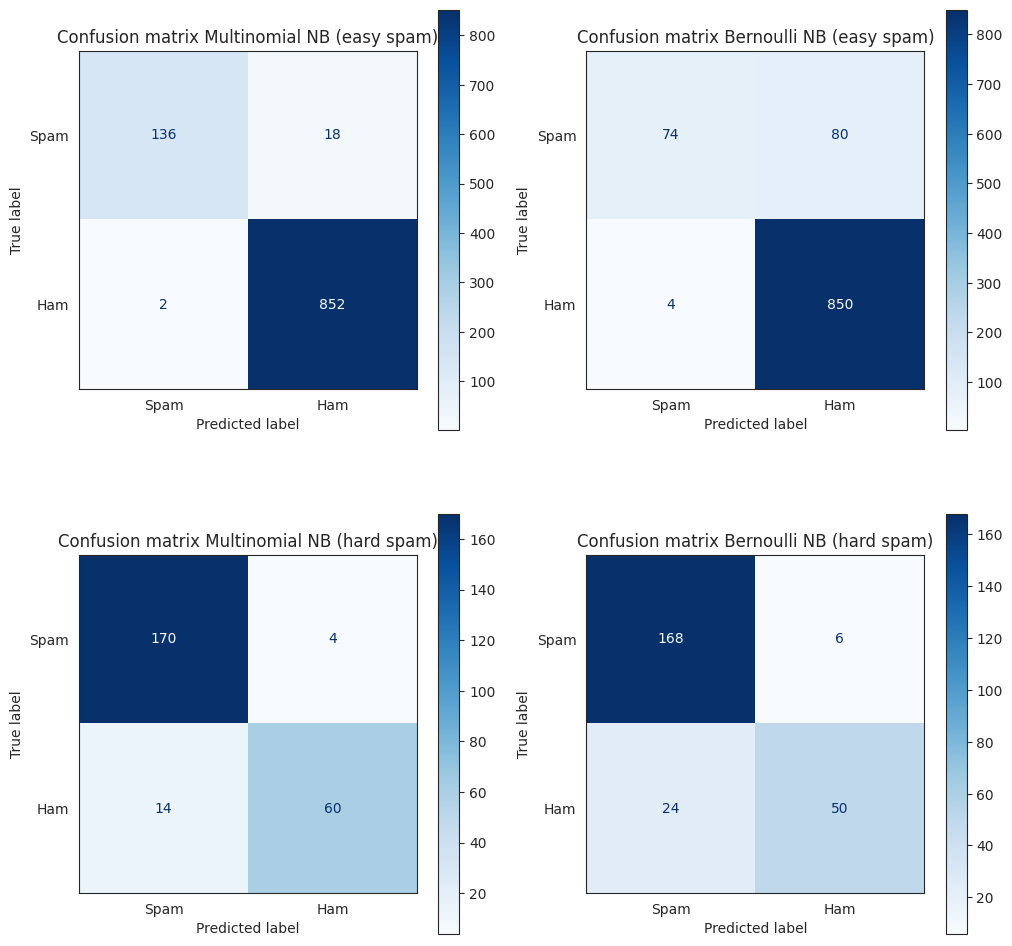

In [25]:
# visualize the confusion matrices to check the performances of the models
with sns.axes_style("white"):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test_easy, y_predict_easy_multi),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[0, 0],
        cmap=plt.cm.Blues, 
        values_format='d'
    )
    axes[0, 0].set_title('Confusion matrix Multinomial NB (easy spam)')

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test_easy, y_predict_easy_berno),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[0, 1],
        cmap=plt.cm.Blues, 
        values_format='d',
    )
    axes[0, 1].set_title('Confusion matrix Bernoulli NB (easy spam)')

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test_hard, y_predict_hard_multi),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[1, 0],
        cmap=plt.cm.Blues, 
        values_format='d',
    )
    axes[1, 0].set_title('Confusion matrix Multinomial NB (hard spam)')

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test_hard, y_predict_hard_berno),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[1, 1],
        cmap=plt.cm.Blues, 
        values_format='d',
    )
    axes[1, 1].set_title('Confusion matrix Bernoulli NB (hard spam)')

In [26]:
print("F1 Score for multinomial Naive Bayes (easy ham):", round(f1_score(y_test_easy, y_predict_easy_multi), 4))
print("F1 Score for Bernoulli Naive Bayes (easy ham):", round(f1_score(y_test_easy, y_predict_easy_berno), 4))
print("F1 Score for multinomial Naive Bayes (hard ham):", round(f1_score(y_test_hard, y_predict_hard_multi), 4))
print("F1 Score for Bernoulli Naive Bayes (hard ham):", round(f1_score(y_test_hard, y_predict_hard_berno), 4))

F1 Score for multinomial Naive Bayes (easy ham): 0.9884
F1 Score for Bernoulli Naive Bayes (easy ham): 0.9529
F1 Score for multinomial Naive Bayes (hard ham): 0.8696
F1 Score for Bernoulli Naive Bayes (hard ham): 0.7692


Judging both by the confusion matrices and the obtained `f1-score`, we can see we obtained worse results using the hard ham datasets. This could be mainly for the following reason: since we have less datapoints comparing to the easy ham, as a consequnce we will also have a less comprehensible vocabulary and thus less features to be fed into the model to leverage the predictions.
In both cases, the `Multinomial Naives Bayes` works better for the reasons mentioned above in question 2. 

### 4.	OPTIONAL - NOT MARKED: 
To avoid classification based on common and uninformative words, it is common practice to filter these out. 

**a.** Think about why this may be useful. Show a few examples of too common and too uncommon words. 

**b.** Use the parameters in *scikit-learn*’s `CountVectorizer` to filter out these words. Update the program from Question 2 and run it on `easy-ham` vs `spam` and `hard-ham` vs `spam`. Report your results.

---

In a tasks like classifying emails like spam or ham based on the text content, identify common and uncommon words between the 2 categories can be crucial on imporving a model performance. Example of common words can be:

- **Articles**: "a," "an," "the"
- **Prepositions**: "in," "on," "at," "by," "with," "for," "of," "to"
- **Conjunctions**: "and," "but," "or," "nor," "so," "yet," "as"
- **Pronouns**: "I," "you," "he," "she," "it," "we," "they," "me," "him," "her," "us," "them"
- **Auxiliary Verbs**: "am," "is," "are," "was," "were," "be," "been," "being," "have," "has," "had," "do," "does," "did," "can," "could," "shall," "should," "will," "would," "may," "might," "must".

Several words, instead, can be so uncommon to the point to be useful in identify a spam email. Some examples could be:

- **mispelled words** ("qu0tes", ...)
- words **related to unsolicited offers** ("free", ...)
- common **phishing keywords** ("lottery", "credit card", ...).

Another thing to take into account can be for example the presence of a lot of punctuations, instead of all caps words or unsubscribe links.

In our case, what we will do now is removing most of the stop words (common words in most the categories mentioned above), to try to improve the classifications performances of both versions of Naive Bayes, in both versions of the dataset (both using "easy spam" and "hard spam"). Furthermore, to try to differenciate even more the categories, we will keep the original case of the words and all of the punctuations.

Since the `scikit-learn` library can have some issues with the list of stopwords in English (as It's described in the uffcial documentation of the `CountVectorizer`), we will use an additional library called `nltk`, very popular for many Natural Language Processing tasks. We will create a function (`text_process`) that can be passed to the original `CountVectorizer` object as a custom text analyzer.

In [ ]:
# import libraries for the additional text preprocessing
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

In [28]:
# analyzer custom function
def text_process(text):
  """
  Function to pre-process text before being
  transformed into bag-of-words 
  """
  
  # remove the stopwords
  return [word for word in text.split() if word not in stopwords.words('english')]


In [29]:
# text preprocessing on the easy dataset 

df_easy_improved = df_easy.copy()

X = CountVectorizer(analyzer=text_process, lowercase=False).fit_transform(df_easy_improved['Content'])
y = df_easy_improved['Ham']

X_easy_improved_train, X_easy_improved_test, y_easy_improved_train, y_easy_improved_test = train_test_split(
    X, y,
    test_size=0.33,
    shuffle=True, 
    random_state=42
)

In [30]:
# models retraining on the easy dataset 

multinomialNB_model_easy_improved = MultinomialNB().fit(X_easy_improved_train, y_easy_improved_train)
y_pred_multi_easy_improved = multinomialNB_model_easy_improved.predict(X_easy_improved_test)

bernoulli_model_easy_improved = BernoulliNB().fit(X_easy_improved_train, y_easy_improved_train)
y_pred_berno_easy_improved = bernoulli_model_easy_improved.predict(X_easy_improved_test)

In [31]:
# text preprocessing on the hard dataset 

df_hard_improved = df_hard.copy()

X = CountVectorizer(analyzer=text_process, lowercase=False).fit_transform(df_hard_improved['Content'])
y = df_hard_improved['Ham']

X_hard_improved_train, X_hard_improved_test, y_hard_improved_train, y_hard_improved_test = train_test_split(
    X, y,
    test_size=0.33,
    shuffle=True, 
    random_state=42
)

In [32]:
# models retraining on the hard dataset 

multinomialNB_model_hard_improved = MultinomialNB().fit(X_hard_improved_train, y_hard_improved_train)
y_pred_multi_hard_improved = multinomialNB_model_hard_improved.predict(X_hard_improved_test)

bernoulli_model_hard_improved = BernoulliNB().fit(X_hard_improved_train, y_hard_improved_train)
y_pred_berno_hard_improved = bernoulli_model_hard_improved.predict(X_hard_improved_test)

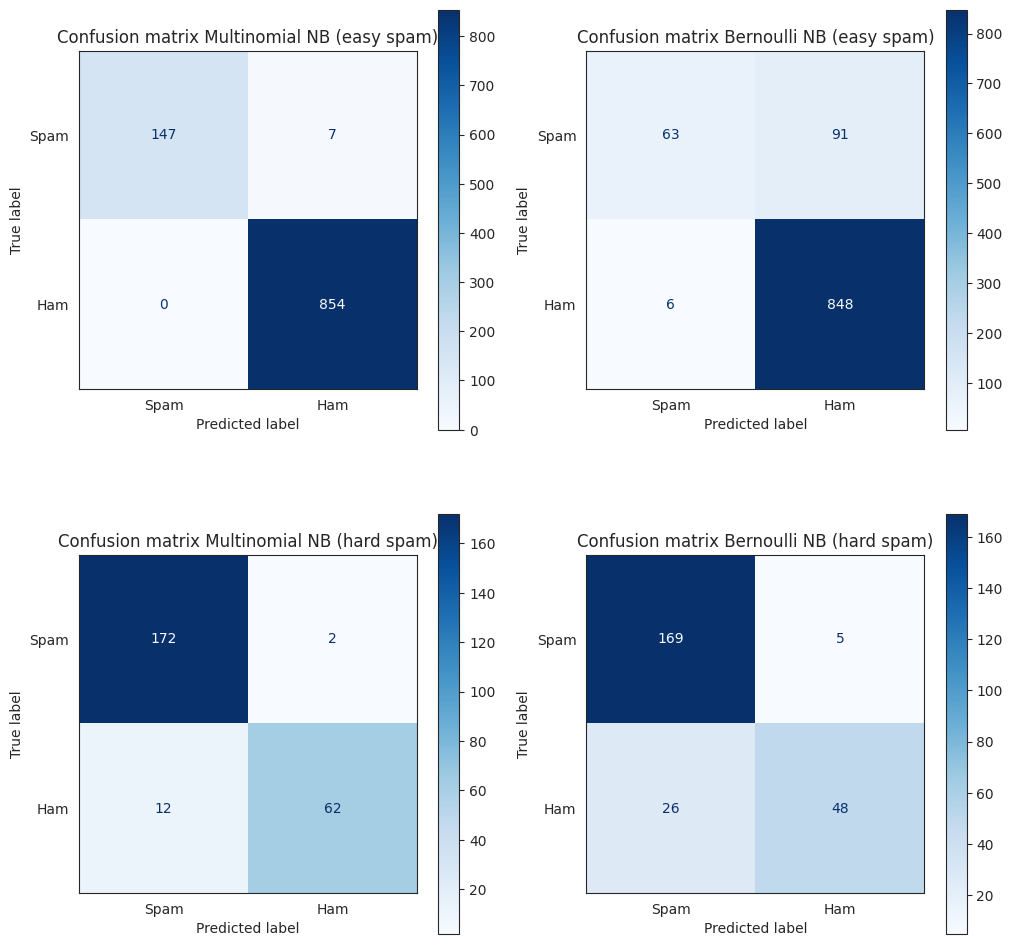

In [33]:
# plots the result with the 4 different confusion matrices

with sns.axes_style("white"):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_easy_improved_test, y_pred_multi_easy_improved),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[0, 0],
        cmap=plt.cm.Blues, 
        values_format='d'
    )
    axes[0, 0].set_title('Confusion matrix Multinomial NB (easy spam)')

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_easy_improved_test, y_pred_berno_easy_improved),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[0, 1],
        cmap=plt.cm.Blues, 
        values_format='d',
    )
    axes[0, 1].set_title('Confusion matrix Bernoulli NB (easy spam)')

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_hard_improved_test, y_pred_multi_hard_improved),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[1, 0],
        cmap=plt.cm.Blues, 
        values_format='d',
    )
    axes[1, 0].set_title('Confusion matrix Multinomial NB (hard spam)')

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_hard_improved_test, y_pred_berno_hard_improved),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[1, 1],
        cmap=plt.cm.Blues, 
        values_format='d',
    )
    axes[1, 1].set_title('Confusion matrix Bernoulli NB (hard spam)')

In [34]:
print("F1 Score for multinomial Naive Bayes (easy ham) (improved version):", round(f1_score(y_easy_improved_test, y_pred_multi_easy_improved), 4))
print("F1 Score for Bernoulli Naive Bayes (easy ham) (improved version):", round(f1_score(y_easy_improved_test, y_pred_berno_easy_improved), 4))
print("F1 Score for multinomial Naive Bayes (hard ham) (improved version):", round(f1_score(y_hard_improved_test, y_pred_multi_hard_improved), 4))
print("F1 Score for Bernoulli Naive Bayes (hard ham) (improved version):", round(f1_score(y_hard_improved_test, y_pred_berno_hard_improved), 4))

F1 Score for multinomial Naive Bayes (easy ham) (improved version): 0.9959
F1 Score for Bernoulli Naive Bayes (easy ham) (improved version): 0.9459
F1 Score for multinomial Naive Bayes (hard ham) (improved version): 0.8986
F1 Score for Bernoulli Naive Bayes (hard ham) (improved version): 0.7559


As we can see from both the confusion matrices and the f1-score values, our assumption at the start of the section were correct! Filtering out common stop words and keeping some typical spam email traits (like the case of the words and the puntuation) helps the models to have a general consistent performance improvement. In particular, a closer look to the confusions matrices suggests a slight improvement especially in classifying spam emails correctly.

For the same reasons stated in the end of the question 3, the dataset with "easy ham" emails continues to outperform the dataset with "hard spam" emails.

A last observation can be that the beneficial of this additional text preprocessing are more for the `Multinomial Naive Bayes` models instead for `Bernoulli Naive Bayes` ones, for the same reasons stated in the second question about the comparison of the 2 versions of Naive Bayes. 

### 5. OPTIONAL - NOT MARKED: Further improving performance
Filter out the headers and footers of the emails before you run on them. The format may vary somewhat between emails, which can make this a bit tricky, so perfect filtering is not required. Run your program again and answer the following questions:

- Does the result improve from those obtained in Questions 3 and 4? 
- What do you expect would happen if your training set consisted mostly of spam messages, while your test set consisted mostly of ham messages, or vice versa? 
- Look at the `fit_prior` parameter. What does this parameter mean? Discuss in what settings it can be helpful (you can also test your hypothesis). 

Before filtering out all of the headers and footers from an email, let's take a look to the structures of both a ham and a spam email. This could be useful to understand how to filter the required specific parts.

In [35]:
# Split the input string into lines
lines = easyhamtrain.sample(n=1).iloc[0]['Content'].splitlines()

# Define a format for each line (e.g., adding a prefix)
formatted_lines = [line for i, line in enumerate(lines)]

# Join the formatted lines back into a single string
formatted_text = '\n'.join(formatted_lines)

# Print the formatted text
print('**Example of ham email** \n')
print(formatted_text)

**Example of ham email** 

From rpm-list-admin@freshrpms.net  Wed Aug 28 13:45:01 2002
Return-Path: <rpm-zzzlist-admin@freshrpms.net>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 96C6E43F99
	for <jm@localhost>; Wed, 28 Aug 2002 08:45:00 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Wed, 28 Aug 2002 13:45:00 +0100 (IST)
Received: from egwn.net (ns2.egwn.net [193.172.5.4]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7SCbXZ24192 for
    <jm-rpm@jmason.org>; Wed, 28 Aug 2002 13:37:33 +0100
Received: from auth02.nl.egwn.net (localhost [127.0.0.1]) by egwn.net
    (8.11.6/8.11.6/EGWN) with ESMTP id g7SCX2J20905; Wed, 28 Aug 2002 14:33:03
    +0200
Received: from bonzo.nirvana (pD9E7EF40.dip.t-dialin.net [217.231.239.64])
    by egwn.net (8.11.6/8.11.6/EGWN) with ESMTP id g7SCWfJ20844 for
    <rpm-list@f

In [36]:
# Split the input string into lines
lines = spamtrain.sample(n=1).iloc[0]['Content'].splitlines()

# Define a format for each line (e.g., adding a prefix)
formatted_lines = [line for i, line in enumerate(lines)]

# Join the formatted lines back into a single string
formatted_text = '\n'.join(formatted_lines)

# Print the formatted text
print('**Example of spam email**\n')
print(formatted_text)

**Example of spam email**

From none@none.com  Mon Sep  2 16:28:01 2002
Return-Path: <none@none.com>
Delivered-To: zzzz@localhost.example.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.example.com (Postfix) with ESMTP id DD0F944171
	for <zzzz@localhost>; Mon,  2 Sep 2002 11:26:45 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Mon, 02 Sep 2002 16:26:45 +0100 (IST)
Received: from 203.160.254.50 (proxy.mon.hu [80.75.224.3]) by
    dogma.slashnull.org (8.11.6/8.11.6) with SMTP id g828eIZ25706 for
    <webmaster@efi.ie>; Mon, 2 Sep 2002 09:40:18 +0100
Message-Id: <200209020840.g828eIZ25706@dogma.slashnull.org>
Received: from unknown (74.38.244.167) by asy100.as122.sol.superonline.com
    with NNFMP; Sep, 02 2002 4:11:57 PM +0400
Received: from 87.15.78.89 ([87.15.78.89]) by pet.vosn.net with local;
    Sep, 02 2002 3:40:05 PM -0000
Received: from unknown (HELO web13708.mail.yahoo.com) (141.52.1

Judging from how the emails in the dataset are structured and how vary can can be both footers and headers, we constructed a function `filter_header_footer` to remove the 2 parts based on common words and patterns. For example:

- in the case of headers, words like "From: " or "Subject: " and the related text will be removed;
- for the footers, instead, we could look for text associated with "Unsubscribe" instead of "Privacy Policy".

In both cases, to recognize patters we will use regular expressions, a convenient way to filter parts of a string based on specific criteria.

In [37]:
import re

In [38]:
def filter_header_footer(email_text):
    """
    Filter the email header and footer given
    its text, mainly using regular expression. 
    Since the format of header and footer can 
    vary much, It will be removed only the general
    cases. 
    """
    
    # filter the header
    header_pattern = re.compile(r"^(From:|To:|Subject:)\s.*$", re.IGNORECASE | re.MULTILINE | re.DOTALL)
    filtered_text = re.sub(header_pattern, '', email_text)

    # filter the footer
    footer_pattern = re.compile(r"(Unsubscribe|Privacy Policy|Copyright).*$", re.IGNORECASE | re.MULTILINE | re.DOTALL)
    filtered_text = re.sub(footer_pattern, '', filtered_text)

    return filtered_text.strip()

Since the main goal of the first point is to check whater the models performance can improve from question 3 or 4 with this strategy, we will use the "hard ham" dataset to train again the models with the filtered emails. 

My hypothesis is that the models could yields worse results compared to the previous ones, since removing headers and footers of emails means also ignoring meaningful information to differiate "spam" from "ham". 

In [39]:
# setting the dataframe and train/test sets

df_hard_filtered = df_hard.copy()
df_hard_filtered['Content'] = df_hard_filtered['Content'].apply(filter_header_footer) 

X = CountVectorizer().fit_transform(df_hard_filtered['Content'])
y = df_hard_filtered['Ham']

X_hard_filtered_train, X_hard_filtered_test, y_hard_filtered_train, y_hard_filtered_test = train_test_split(
    X, y,
    test_size=0.33,
    shuffle=True, 
    random_state=42
)

In [40]:
# models retraining on the hard dataset 

multinomialNB_model_hard_filtered = MultinomialNB().fit(X_hard_filtered_train, y_hard_filtered_train)
y_pred_multi_hard_filtered = multinomialNB_model_hard_filtered.predict(X_hard_filtered_test)

bernoulli_model_hard_filtered = BernoulliNB().fit(X_hard_filtered_train, y_hard_filtered_train)
y_pred_berno_hard_filtered = bernoulli_model_hard_filtered.predict(X_hard_filtered_test)

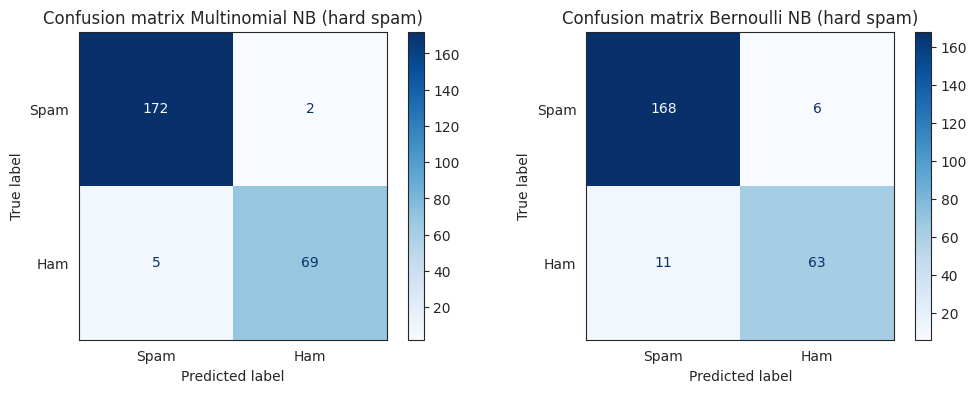

In [41]:
# visualize the confusion matrices to check the performances of the models
with sns.axes_style("white"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_hard_filtered_test, y_pred_multi_hard_filtered),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[0],
        cmap=plt.cm.Blues, 
        values_format='d'
    )
    axes[0].set_title('Confusion matrix Multinomial NB (hard spam)')

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_hard_filtered_test, y_pred_berno_hard_filtered),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[1],
        cmap=plt.cm.Blues, 
        values_format='d',
    )
    axes[1].set_title('Confusion matrix Bernoulli NB (hard spam)')

In [42]:
print("F1 Score for multinomial Naive Bayes (hard ham):", round(f1_score(y_test_hard, y_predict_hard_multi), 4))
print("F1 Score for Bernoulli Naive Bayes (hard ham):", round(f1_score(y_test_hard, y_predict_hard_berno), 4))
print("F1 Score for multinomial Naive Bayes (hard ham) (improved version):", round(f1_score(y_hard_improved_test, y_pred_multi_hard_improved), 4))
print("F1 Score for Bernoulli Naive Bayes (hard ham) (improved version):", round(f1_score(y_hard_improved_test, y_pred_berno_hard_improved), 4))
print("F1 Score for multinomial Naive Bayes (hard ham) (with headers and footers filtered):", round(f1_score(y_hard_filtered_test, y_pred_multi_hard_filtered), 4))
print("F1 Score for Bernoulli Naive Bayes (hard ham) (with headers and footers filtered):", round(f1_score(y_hard_filtered_test, y_pred_berno_hard_filtered), 4))


F1 Score for multinomial Naive Bayes (hard ham): 0.8696
F1 Score for Bernoulli Naive Bayes (hard ham): 0.7692
F1 Score for multinomial Naive Bayes (hard ham) (improved version): 0.8986
F1 Score for Bernoulli Naive Bayes (hard ham) (improved version): 0.7559
F1 Score for multinomial Naive Bayes (hard ham) (with headers and footers filtered): 0.9517
F1 Score for Bernoulli Naive Bayes (hard ham) (with headers and footers filtered): 0.8811


In contrast to my hypothesis, removing common header and footer information from the emails helps in outperforming not only the first models without NLP enhancements, but also the versions where we removed the stop words!

There could be several reasons behind this improvement:

- even though headers and footers could contain useful information to differentiate the 2 categories, **in most cases they could just add more noise to the analyzed text data**. Removing those parts allowed the Naive Bayes models to more focus on the emails' bodies, the main source of the contents.
- also due to the large variaety of the headers and the footers, **also relying to those part of an email could lead to overfitting problems**; this especially with Naive Bayes models, since they are really sensible to potential irrilevant and noisy features. The filtering helps the models to improve the feature extraction of more relevant information and normalize the text content, resulting in a more meaningful words vocabulary to analyze in training and then making predictions.


---

Let's now consider the second point of the question, which present a particular case of our task: *when the training set consists mostly of spam messages while your test set consisted mostly of ham messages, and vice versa.*
Usually, when the training phase is made with an imbalanced dataset, what we could get is a model that tends to overfit towards the dominant class. This applies even more in context like classifying document based on text data and using Naive based models. 

Always taking into account the sensibility of the mentioned probabilistic models to the features, **what I expect using a dataset of mostly ham/spam emails is having a words vocabulary (the features) more biased to the dominant class; and, as a consequence, poorer predictions result if the test set used mostly consists of emails of the other category.**

---

In the last point of the question and the assignment, we will take a closer look to the `fit_prior` parameter of both Naive Bayes models. Like also the `scikit-learn` library states, **`fit_prior` allows to decide whether to learn class prior probabilities or not**, always based on the available features generated by the `CountVectorizer`. **If that the parameter will be set to `False`, a uniform prior will be assumed among the possible categories.**

Till now, all the probabilistic models trained assumed class prior probabilities. Considering the last dataset version (the one with "hard ham" and headers and footers filtered), what we will try now is to assume a prior uniform probability for both Multinomial and Bernoulli Naive Bayes. *My hypothesis is a further potential impovement of the model*, mainly for 2 reasons:

- since "hard spam" is a pretty balanced dataset, setting `fit_prior=True` could ensure that the models won't have any preferences towards a specific class and treat them both equally;
- the dataset used is not that big (we have around 400 datapoints including both ham and spam emails), so assuming uniform probability could helps us reduce the risk of overfitting.

In [43]:
# models retraining on the hard dataset (with fit_priors=False)

multinomialNB_model_hard_filtered_uniform = MultinomialNB(fit_prior=False).fit(X_hard_filtered_train, y_hard_filtered_train)
y_pred_multi_hard_filtered_uniform = multinomialNB_model_hard_filtered_uniform.predict(X_hard_filtered_test)

bernoulli_model_hard_filtered_uniform = BernoulliNB(fit_prior=False).fit(X_hard_filtered_train, y_hard_filtered_train)
y_pred_berno_hard_filtered_uniform = bernoulli_model_hard_filtered_uniform.predict(X_hard_filtered_test)

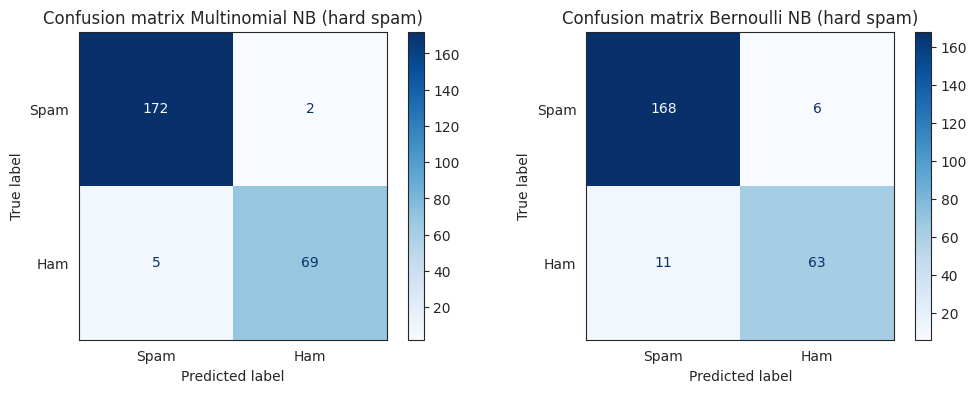

In [44]:
# visualize the confusion matrices to check the performances of the models
with sns.axes_style("white"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_hard_filtered_test, y_pred_multi_hard_filtered_uniform),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[0],
        cmap=plt.cm.Blues, 
        values_format='d'
    )
    axes[0].set_title('Confusion matrix Multinomial NB (hard spam)')

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_hard_filtered_test, y_pred_berno_hard_filtered_uniform),
        display_labels=['Spam', 'Ham'],
    ).plot(
        ax=axes[1],
        cmap=plt.cm.Blues, 
        values_format='d',
    )
    axes[1].set_title('Confusion matrix Bernoulli NB (hard spam)')

In [45]:
print("F1 Score for multinomial Naive Bayes (hard ham) (with headers and footers filtered, assuming prior uniform probability):", round(f1_score(y_hard_filtered_test, y_pred_multi_hard_filtered_uniform), 4))
print("F1 Score for Bernoulli Naive Bayes (hard ham) (with headers and footers filtered, assuming prior uniform probability):", round(f1_score(y_hard_filtered_test, y_pred_berno_hard_filtered_uniform), 4))

F1 Score for multinomial Naive Bayes (hard ham) (with headers and footers filtered, assuming prior uniform probability): 0.9517
F1 Score for Bernoulli Naive Bayes (hard ham) (with headers and footers filtered, assuming prior uniform probability): 0.8811


Also in this case, although our hypothesis, asssuming uniform prior probabilities doesn't change the performance of the model at all. A potential reason of this behavior is having the dataset balanced enough to not encounter a risk to tend for a specific classes; in addition, the size of the data could be large enough to have low risk of overfitting for our task.

Also, *assuming uniform probabilities in porbabilistic models like Naive Bayes could be more impactful on unbalanced datasets*, since:

- having more class frequences of a category combined with prior assumption could be another source of potential overfitting;
- uniform asusmption could prevent biases towards the majority classs.